In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import csv
import seaborn as sns
plt.style.use('fivethirtyeight')
import numpy as np
import datetime
import re
import time
import json

In [2]:
log_path = "logs/SCHED_"
algos = ["RR", "RANDOM", "LL"]
algo_idx = 2

In [3]:
log_file = log_path + algos[algo_idx]

In [4]:
master_log = log_file + "/master.log"
conf_path = "config.json"
config_file = open(conf_path, "r")
json_data = json.load(config_file)
config_file.close()

worker_ids = []
workers = json_data["workers"]
for worker in workers:
    worker_id = worker["worker_id"]
    worker_ids.append(worker_id)

worker_logs = []
for worker_id in worker_ids:
    worker_logs.append(log_file + "/worker_" + str(worker_id) + ".log")


In [5]:
# Parsing jobs
job_arrival_pattern = r"\[(.*)\] Job arrived: (.*)"
job_ending_pattern = r"\[(.*)\] Completed job: (.*)"

# Parsing tasks
task_arrival_pattern = r"\[(.*)\] Task arrived: (.*)"
task_ending_pattern = r"\[(.*)\] Completed task: (.*)"

In [6]:
def duration(start, end):
    start = datetime.datetime.strptime(start, "%Y-%m-%d %H:%M:%S.%f")
    end = datetime.datetime.strptime(end, "%Y-%m-%d %H:%M:%S.%f")
    
    duration = end - start
    
    elapsed = float((duration.days * 86400) + (duration.seconds * 1) + float(duration.microseconds / 1000) / 1000)
    
    return elapsed

In [7]:
f = open(master_log, "r")
lines = f.readlines()
f.close()

In [8]:
def compute_stats(lines, arrival_pattern, ending_pattern):
    times = dict()
    for line in lines:
        start = re.match(arrival_pattern, line)
        if start:
            timestamp, Id = start.groups()
            times[Id] = timestamp
            continue

        end = re.search(ending_pattern, line)
        if end:
            end_timestamp, Id = end.groups()
            start_timestamp = times[Id]

            time_duration = duration(start_timestamp, end_timestamp)

            times[Id] = time_duration
    times = pd.DataFrame(times.values(), columns=["durations"])
    mean = times["durations"].mean()
    median = times["durations"].median()
    
    return mean, median

In [9]:
job_mean, job_median = compute_stats(lines, job_arrival_pattern, job_ending_pattern)
print(job_mean, job_median)

(5.922000000000001, 6.0115)


In [10]:
lines = []

for worker_log in worker_logs:
      with open(worker_log, "r") as f:
            lines += f.readlines()

In [11]:
task_mean, task_median = compute_stats(lines, task_arrival_pattern, task_ending_pattern)
print(task_mean, task_median)

(2.3751897435897433, 2.002)


In [12]:
f = open(master_log, "r")
base_line = f.readline()
f.close()

base_match = re.match(job_arrival_pattern, base_line)
if base_match:
    base, _ = base_match.groups()

In [13]:
def get_plot_vals(lines, task_arrival_pattern, task_ending_pattern, base):
    stats = []
    for line in lines:
        start_match = re.match(task_arrival_pattern, line)
        if start_match:
            start_time, _ = start_match.groups()
            diff = duration(base, start_time)
            stats.append([diff, 1])
            continue

        end_match = re.match(task_ending_pattern, line)
        if end_match:
            end_time, _ = end_match.groups()
            diff = duration(base, end_time)
            stats.append([diff, -1])
            continue

    x = [i[0] for i in stats]
    y = [i[1] for i in stats]
    y = [sum(y[:i]) for i in range(1, len(y)+1)]
    return x, y

In [14]:
def plot_scatter(lines, task_arrival_pattern, task_ending_pattern, base, worker_id):
    x, y = get_plot_vals(lines, task_arrival_pattern, task_ending_pattern, base)
    plt.figure(figsize=(15, 10))
    title = "Algorithm: " + algos[algo_idx] + ": Number of tasks running on worker " + worker_id + " against time."
    plt.figtext(.5,.9,title, fontsize=25, ha='center')
    plt.rc('xtick', labelsize=20)    
    plt.rc('ytick', labelsize=20)
    plt.scatter(x, y, color = (0.5,0.1,0.5,0.6))
    plt.xlabel("Time in seconds", fontsize=20)
    plt.ylabel("Number of tasks", fontsize=20)
    file_name = "scatter" + algos[algo_idx] + "worker" + worker_id + ".png"
    plt.savefig(file_name)

In [15]:
def plot_line(lines, task_arrival_pattern, task_ending_pattern, base, worker_id):
    x, y = get_plot_vals(lines, task_arrival_pattern, task_ending_pattern, base)
    plt.figure(figsize=(15, 10))
    title = "Algorithm: " + algos[algo_idx] + ": Number of tasks running on worker " + worker_id + " against time."
    plt.figtext(.5,.9,title, fontsize=25, ha='center')
    plt.rc('xtick', labelsize=20)    
    plt.rc('ytick', labelsize=20)
    plt.plot(x, y, 'b')
    plt.xlabel("Time in seconds", fontsize=20)
    plt.ylabel("Number of tasks", fontsize=20)
    file_name = "line" + algos[algo_idx] + "worker" + worker_id + ".png"
    plt.savefig(file_name)

In [16]:
def plot_bar(lines, task_arrival_pattern, task_ending_pattern, base, worker_id):
    x, y = get_plot_vals(lines, task_arrival_pattern, task_ending_pattern, base)
    x_bar = [i for i in range(len(x))]
    y_bar = y

    plt.figure(figsize=(15, 10))
    title = "Algorithm: " + algos[algo_idx] + ": Number of tasks running on worker " + worker_id + " against event logs."
    plt.figtext(.5,.9,title, fontsize=25, ha='center')
    plt.rc('xtick', labelsize=20)    
    plt.rc('ytick', labelsize=20)
    plt.bar(x_bar, y_bar)
    plt.xlabel("Series of events", fontsize=20)
    plt.ylabel("Number of tasks", fontsize=20)
    file_name = "bar" + algos[algo_idx] + "worker" + worker_id + ".png"
    plt.savefig(file_name)

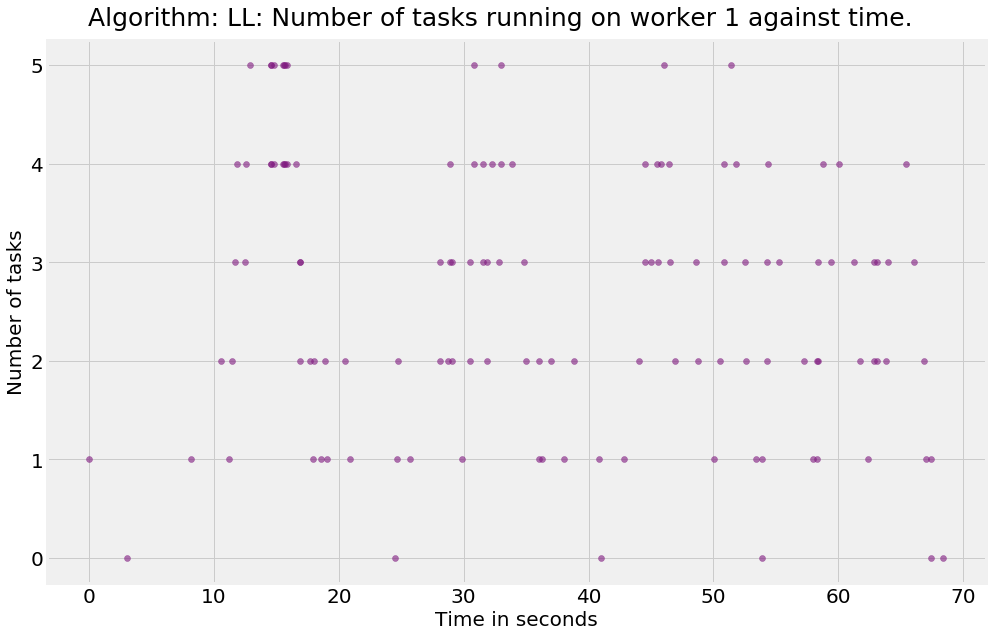

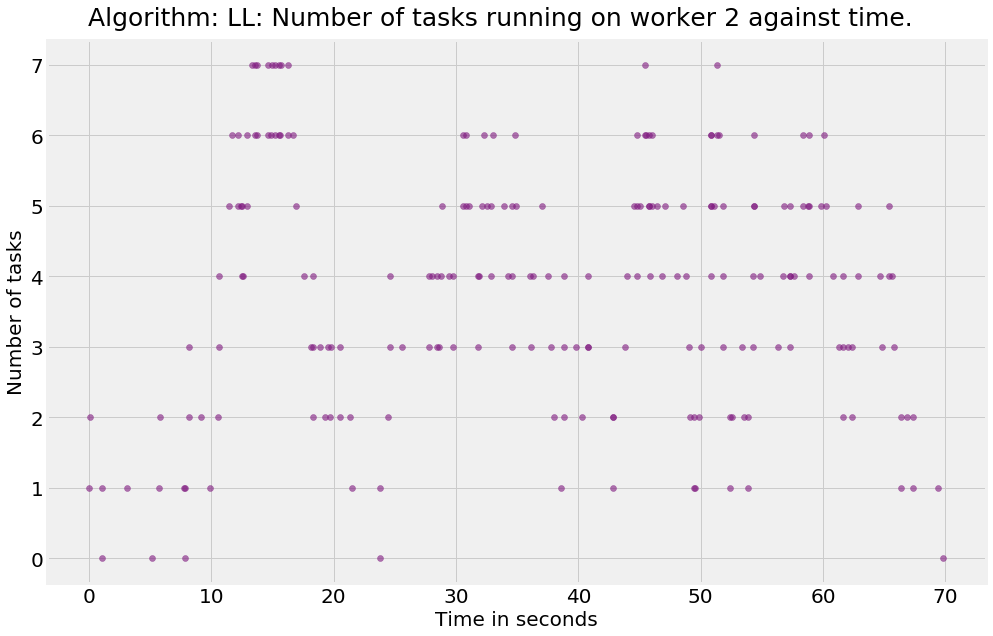

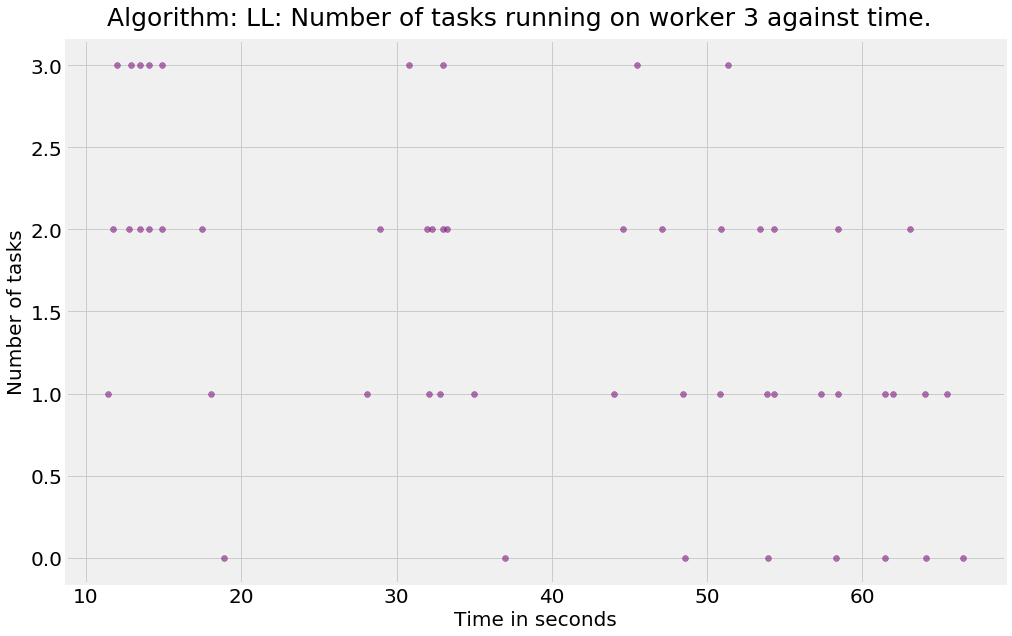

In [17]:
for worker_log in worker_logs:
    with open(worker_log, "r") as f:
        lines = f.readlines()
    worker_id = worker_log.split("/")[-1]
    worker_id = worker_id.split("_")[-1]
    worker_id = worker_id.split(".")[0]
    plot_scatter(lines, task_arrival_pattern, task_ending_pattern, base, worker_id)

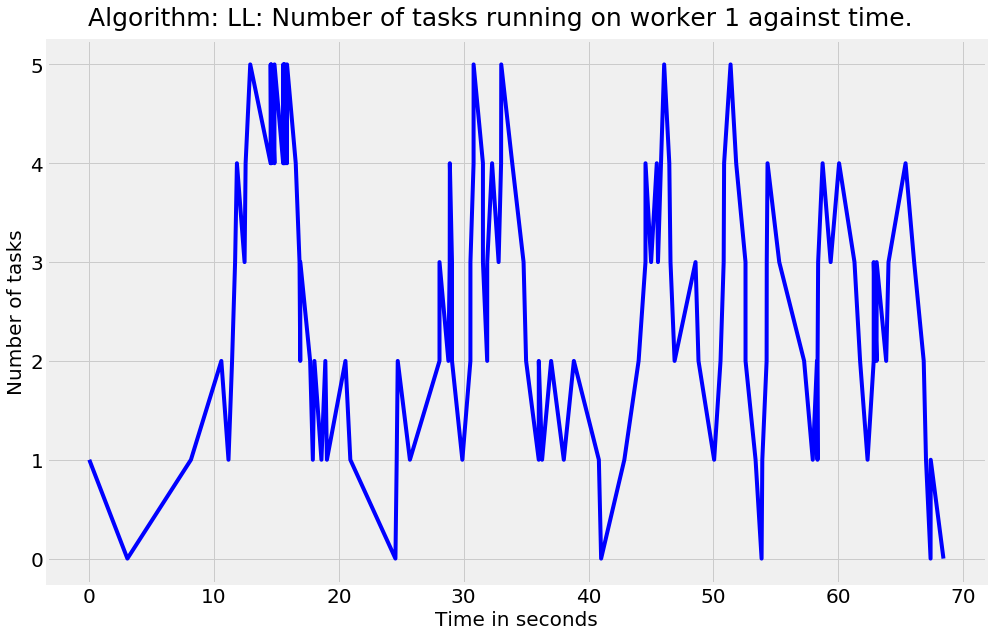

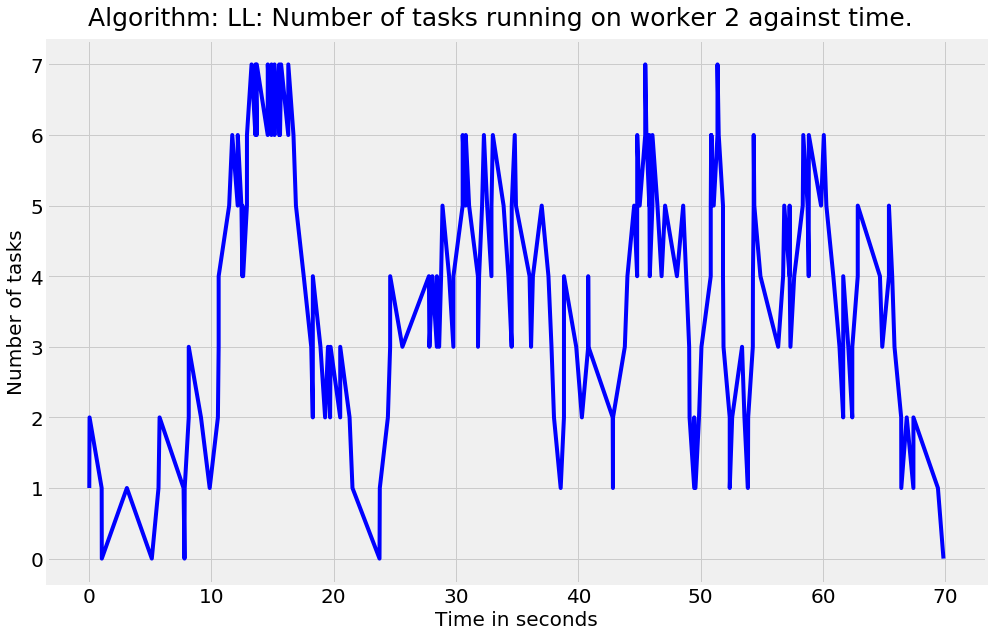

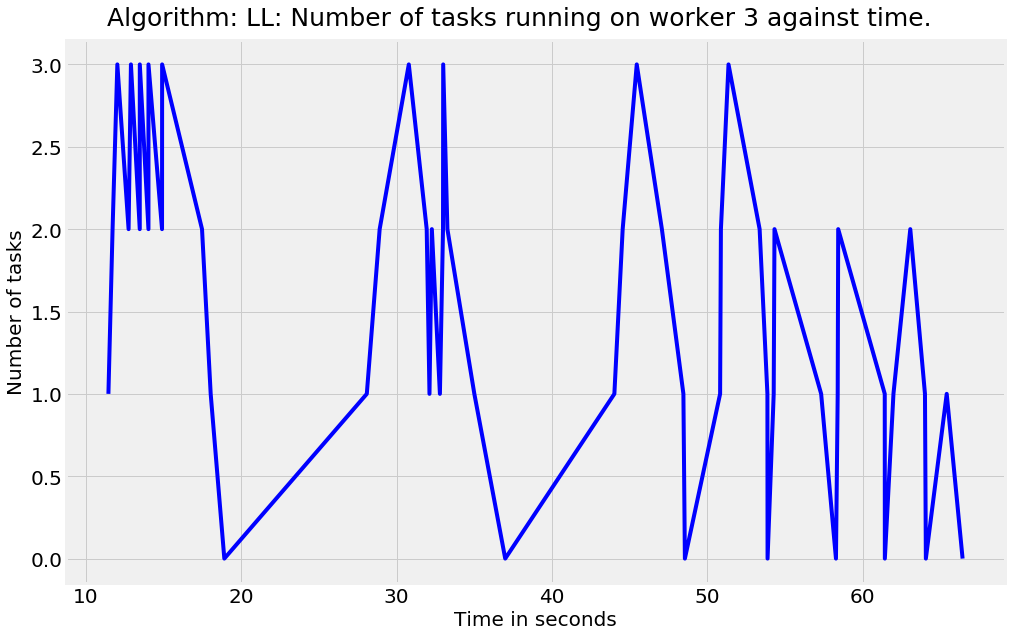

In [18]:
for worker_log in worker_logs:
    with open(worker_log, "r") as f:
        lines = f.readlines()
    worker_id = worker_log.split("/")[-1]
    worker_id = worker_id.split("_")[-1]
    worker_id = worker_id.split(".")[0]
    plot_line(lines, task_arrival_pattern, task_ending_pattern, base, worker_id)

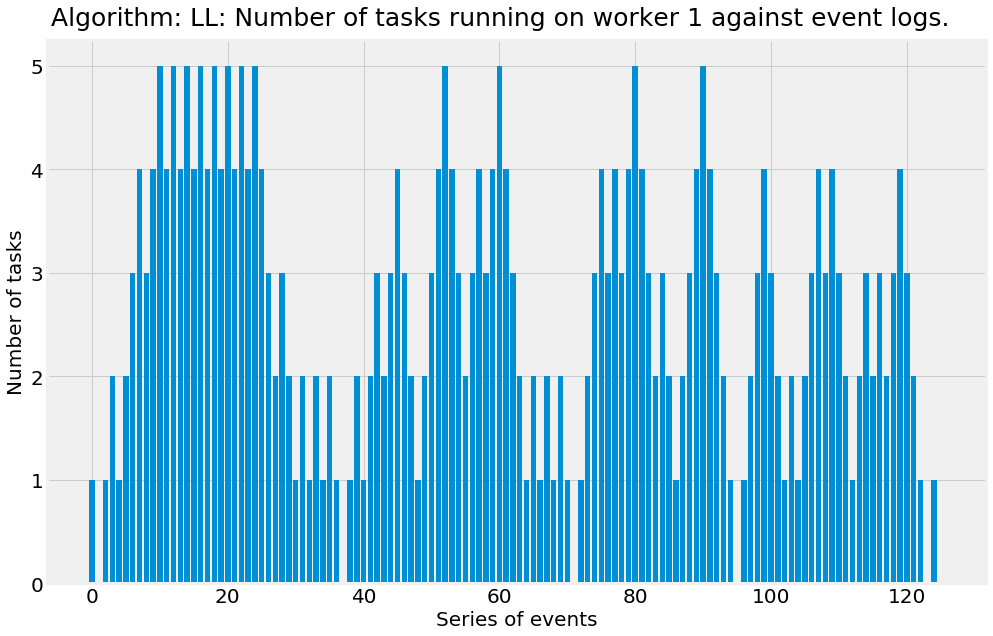

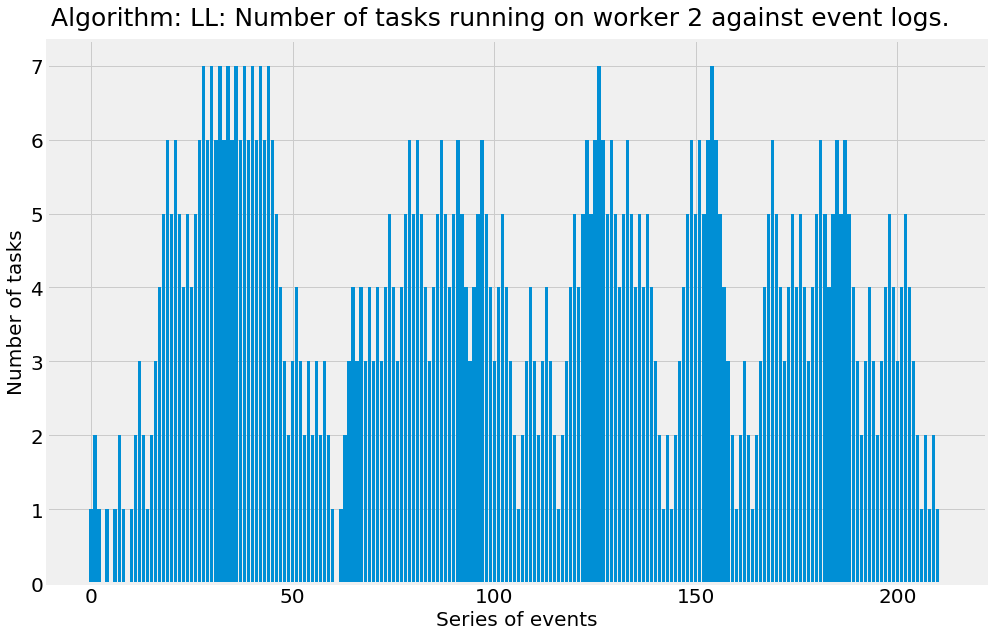

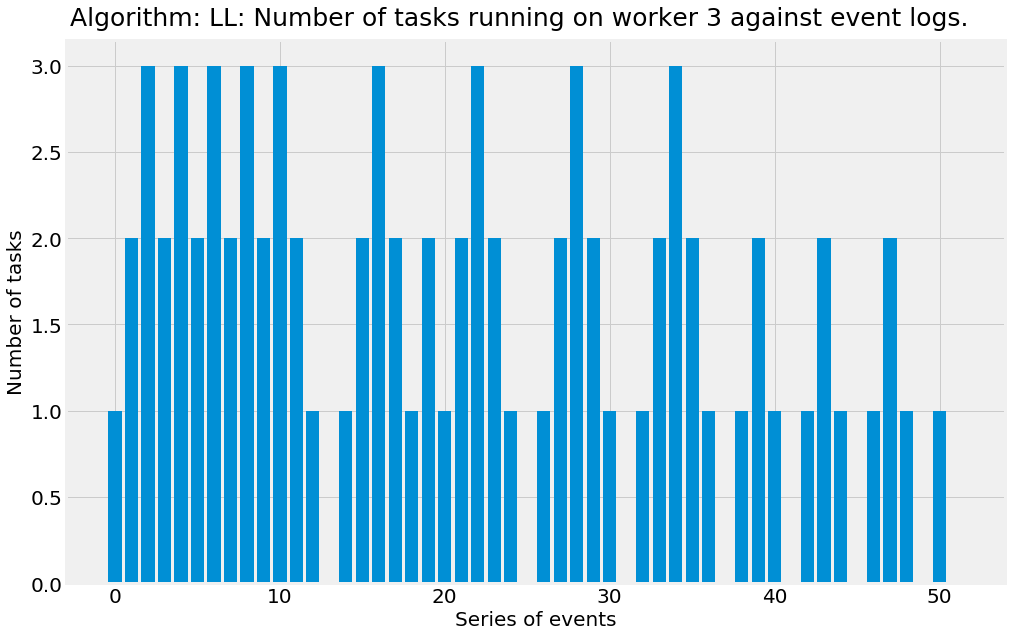

In [19]:
for worker_log in worker_logs:
    with open(worker_log, "r") as f:
        lines = f.readlines()
    worker_id = worker_log.split("/")[-1]
    worker_id = worker_id.split("_")[-1]
    worker_id = worker_id.split(".")[0]
    plot_bar(lines, task_arrival_pattern, task_ending_pattern, base, worker_id)